In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# local imports
from src import Compose_Event, Draw_Compose_Event
from src import SttCSVReader, Draw_Reader_Event

### _Dataset_

In [6]:
# mu+mu- data (current)
input_dir = './train_quick'

In [7]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, ''))
                       for f in all_files if f.endswith(suffix))

In [8]:
# file_prefixes[:10]

In [9]:
# load an event
event_prefix = file_prefixes[4]
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000004 memory usage 0.10 MB


In [10]:
# hits.head()
# tubes.head()
# particles.head()
# truth.head()

### SttCSVReader

In [28]:
# reader = SttCSVReader(path=input_dir,selection=True,noise=False,skewed=False)

In [29]:
# event_id = 4
# read = reader(event_id)

In [30]:
# read.event.pdgcode.unique()

In [31]:
# Draw_Reader_Event(data=read,figsize=(9,9),save_fig=False);

### _Compose Event_

- `SttCSVReader` has some issues with particle filtering
- _Same as `select_hits()` in `processing/utils/event_utils.py`_

In [32]:
event = Compose_Event(event_prefix, noise=False, skewed=False)

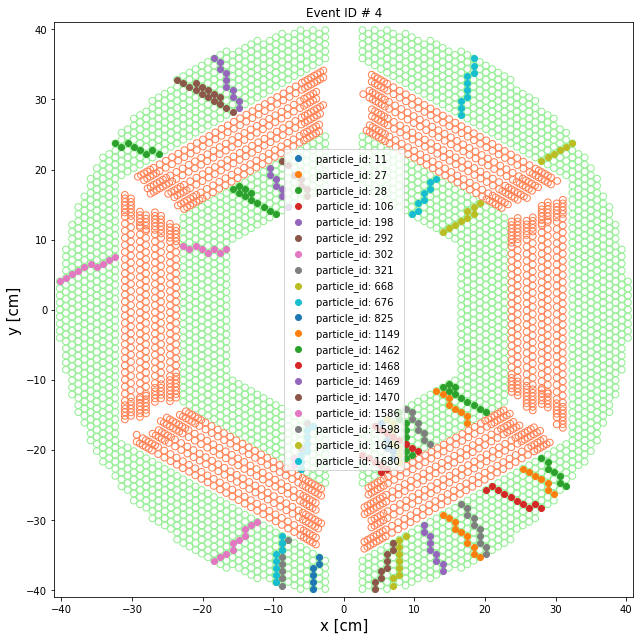

In [33]:
Draw_Compose_Event(event,figsize=(9,9),save_fig=False);

- _further analysis_

In [16]:
# read.event_file

In [17]:
# read.hits.head()
# read.tubes.head()
# read.particles.head()
# read.event.head()

In [18]:
# read.event.layer.unique()

In [34]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary,pt,peta
0,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,12,-2212,0.057166,0,0.293976,0.133939
1,27,9.53075,-25.574699,4.394530,0.104148,-0.074822,0.167964,1,14,2212,5.208580,0,0.128238,1.084400
2,28,9.53075,-25.574699,4.394530,-0.006043,0.167746,-0.100700,-1,43,-211,5.208580,0,0.167855,-0.568759
3,106,9.53075,-25.574699,4.394530,-0.122544,0.074333,0.414283,1,10,211,5.208580,0,0.143326,1.783236
4,198,9.53075,-25.574699,4.394530,0.039001,-0.151349,-0.261074,-1,13,-211,5.208580,0,0.156293,-1.285721


- _Drop Duplicates in "Particles"_

In [35]:
# particles = event.particles.copy() # copy() it otherwise event.particles is changed
# particles['nhits'] = particles.groupby(['particle_id'])['nhits'].transform('count')
# particles.drop_duplicates(inplace=True, ignore_index=True)
# particles.head(10)

- _Filter some particles in "Particles"_

In [36]:
# there are particle we don't need e.g. electron (11), (1000010020), etc
particles.pdgcode.unique()

array([-2212,  2212,  -211,   211])

In [37]:
# see all particle in the particle dataframe
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary,pt,peta
0,11,0.08434,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,12,-2212,0.057166,0,0.293976,0.133939
1,27,9.53075,-25.574699,4.394530,0.104148,-0.074822,0.167964,1,14,2212,5.208580,0,0.128238,1.084400
2,28,9.53075,-25.574699,4.394530,-0.006043,0.167746,-0.100700,-1,43,-211,5.208580,0,0.167855,-0.568759
3,106,9.53075,-25.574699,4.394530,-0.122544,0.074333,0.414283,1,10,211,5.208580,0,0.143326,1.783236
4,198,9.53075,-25.574699,4.394530,0.039001,-0.151349,-0.261074,-1,13,-211,5.208580,0,0.156293,-1.285721


In [38]:
# just keep protons, pions and maybe muon, don't forget resetting index and dropping old one.
particles[particles['pdgcode'].isin([-2212, 2212, -211, 211])].reset_index(drop=True)

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary,pt,peta
0,11,0.084340,-0.636486,0.110118,0.085245,-0.281345,0.039492,-1,12,-2212,0.057166,0,0.293976,0.133939
1,27,9.530750,-25.574699,4.394530,0.104148,-0.074822,0.167964,1,14,2212,5.208580,0,0.128238,1.084400
2,28,9.530750,-25.574699,4.394530,-0.006043,0.167746,-0.100700,-1,43,-211,5.208580,0,0.167855,-0.568759
3,106,9.530750,-25.574699,4.394530,-0.122544,0.074333,0.414283,1,10,211,5.208580,0,0.143326,1.783236
4,198,9.530750,-25.574699,4.394530,0.039001,-0.151349,-0.261074,-1,13,-211,5.208580,0,0.156293,-1.285721
5,292,9.530750,-25.574699,4.394530,-0.052070,-0.208088,0.003626,1,15,211,5.208580,0,0.214504,0.016901
6,302,0.084340,-0.636486,0.110118,-0.025884,-0.166637,0.038013,1,26,211,0.057166,0,0.168635,0.223546
7,321,-0.354174,-1.972890,1.691100,-0.199892,-0.545062,0.477212,-1,26,-2212,0.140684,0,0.580560,0.749745
8,668,-0.354174,-1.972890,1.691100,0.080265,-0.121308,0.093980,1,28,211,0.140684,0,0.145458,0.607951
9,676,-1.008570,-4.289330,-1.759960,-0.296903,-0.908326,-0.346407,-1,24,-2212,0.209356,0,0.955619,-0.354992


- _renaming layers_

In [39]:
# hits.head()

In [40]:
# vlids = hits.layer_id.unique()
# n_det_layers == len(vlids)
# vlid_groups = hits.groupby(['layer_id'])
# hits = pd.concat([vlid_groups.get_group(vlids[i]).assign(layer_id=i) for i in range(n_det_layers)])  # need reset index

In [41]:
# hits.head()